In [1]:
from imutils.perspective import four_point_transform
from imutils import contours as COUNTOURS
import numpy as np
import imutils
import cv2
import sys
import matplotlib.pyplot as plt

def show_images(images, titles=None):
    n_ims = len(images)
    if titles is None:
        titles = ['(%d)' % i for i in range(1, n_ims + 1)]
    fig = plt.figure()
    n = 1
    for image, title in zip(images, titles):
        a = fig.add_subplot(1, n_ims, n)
        if image.ndim == 2:
            plt.gray()
        plt.imshow(image)
        a.set_title(title)
        n += 1
    fig.set_size_inches(np.array(fig.get_size_inches()) * n_ims)
    plt.show()


In [2]:
def isExiste(gray_image):
    thresh = cv2.threshold(
        gray_image, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]
    kernal = np.ones((2, 2), np.uint8)
    thresh_closed = cv2.morphologyEx(
        thresh, cv2.MORPH_CLOSE, kernal, iterations=1)
    contours = cv2.findContours(
        thresh_closed.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contours = imutils.grab_contours(contours)
    questionCnts = []
    position_of_first_bubble = sys.maxsize  # MAX
    bubble_info = []
    for cnt in contours:
        (x, y, w, h) = cv2.boundingRect(cnt)
        ar = w / float(h)
        if w >= 13 and h >= 11 and ar >= 0.7 and ar <= 1.2:
            bubble_info = [x, y, w, h]
            questionCnts.append(cnt)
            position_of_first_bubble = min(position_of_first_bubble, x)
    count_of_bubbles = len(questionCnts)
    return [count_of_bubbles, bubble_info]

def isValid(bubbles_positions, window_height):
    length = len(bubbles_positions)
    if (length > 0):
        first_bubble = bubbles_positions[0]
        last_bubble = bubbles_positions[length - 1]
        if (abs(first_bubble - last_bubble) >= 10):
            return False
        else:
            return True
    else:
        return False

def getRowBubbles(gray_image):
    thresh = cv2.threshold(
        gray_image, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]
    kernal = np.ones((2, 2), np.uint8)
    thresh_closed = cv2.morphologyEx(
        thresh, cv2.MORPH_CLOSE, kernal, iterations=2)
    contours = cv2.findContours(
        thresh_closed.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contours = imutils.grab_contours(contours)
    questionCnts = []
    y_positions = []
    position_of_first_bubble = sys.maxsize 
    x_positions = []
    space_between_two_bubbles = 0
    for cnt in contours:
        (x, y, w, h) = cv2.boundingRect(cnt)
        ar = w / float(h)
        if w >= 13 and h >= 11 and ar >= 0.7 and ar <= 1.2:
            questionCnts.append(cnt)
            y_positions.append(y)
            position_of_first_bubble = min(position_of_first_bubble, x)
            x_positions.append(x)

            # x_position = x
    count_of_bubbles = len(questionCnts)
    x_positions = sorted(x_positions, reverse=False)
    y_positions = sorted(y_positions, reverse=False)
    space_between_two_bubbles = abs(x_positions[0] - x_positions[1])
    return [count_of_bubbles, position_of_first_bubble, space_between_two_bubbles, y_positions, x_positions]

def detectRow(img, window_height=60):
    height = img.shape[0]
    width = img.shape[1]
    step_width = window_height
    finished = False
    start_position = (height // 4) - 15

    while not finished:
        cropped_row = img[start_position: start_position + step_width, 0:width]
        start_position += step_width
        [found_bubble, position_of_first_bubble, space_between_two_bubbles,
            y_positions, x_positions] = getRowBubbles(cropped_row)
        if (found_bubble > 0):
            if (isValid(y_positions, step_width)):
                row_bubbles_count = found_bubble
                finished = True
            else:
                step_width -= 10
    return [cropped_row, row_bubbles_count, position_of_first_bubble, space_between_two_bubbles, x_positions]

def isSimilarBubble(first, second):
    if (abs(first[1] - second[1]) > 5):
        return False
    if (abs(first[2] - second[2]) > 5):
        return False
    if (abs(first[3] - second[3]) > 5):
        return False
    return True

def getBubblesNum(img, position_of_first_bubble=0, space_between_two_bubbles=20):
    height = img.shape[0]
    step_width = space_between_two_bubbles

    finished = False
    bubbles_counter = 0
    start_position = position_of_first_bubble - 2
    bubble_cropped = img[0:height, start_position:start_position+step_width]
    [bubbles_counter, old_bubble_info] = isExiste(bubble_cropped)
    start_position += step_width
    while not finished:
        bubble_cropped = img[0:height,start_position:start_position+step_width]
        start_position += step_width
        [found_bubble, new_bubble_info] = isExiste(bubble_cropped)
        if (found_bubble > 0):
            if (isSimilarBubble(old_bubble_info, new_bubble_info)):
                bubbles_counter += found_bubble
                old_bubble_info = new_bubble_info
            else:
                finished = True
        else:
            finished = True
    return bubbles_counter

def resize_image(img):
    height = img.shape[0]
    width = img.shape[1]

    if (height > 800):
        ratio = height / 800
        new_height = round(height / ratio)
        new_width = round(width / ratio)
        resized_image = cv2.resize(img, (new_width, new_height))
        return resized_image
    else:
        return img

def cropIntoSections(img, num_of_sections, x_positions):
    height = img.shape[0]
    results = []
    positions = np.copy(x_positions)
    groups = np.array_split(positions, num_of_sections)
    bubble_width = abs(positions[0] - positions[1])
    for i in range(num_of_sections):
        start_width = groups[i][0] - 10
        end_width = groups[i][len(groups[i]) - 1] + bubble_width
        results.append(img[0:height, start_width:end_width])
    return results

def rmContours(contours, contours_y_coordinates, question_answers_count):
    first_group_info = contours_y_coordinates[0:question_answers_count]
    last_group_info = contours_y_coordinates[len(
        contours) - question_answers_count:len(contours)]
    if (abs(first_group_info[0] - first_group_info[question_answers_count - 1]) > 5):
        contours.pop(0)
    if (abs(last_group_info[0] - last_group_info[question_answers_count - 1]) > 5):
        contours.pop(len(contours) - 1)
    return

def retrieveId(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)
    edged = cv2.Canny(blurred, 75, 200)
    kernal = np.ones((3, 3), np.uint8)
    after_dilation = cv2.dilate(edged, kernal, iterations=2)

    contours = cv2.findContours(after_dilation.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contours = imutils.grab_contours(contours)
    idBox = None

    contours = sorted(contours, key=cv2.contourArea, reverse=True)
    if len(contours) > 0:
        contours = sorted(contours, key=cv2.contourArea, reverse=True)
        for cnt in contours:
            peri = cv2.arcLength(cnt, True)
            approx = cv2.approxPolyDP(cnt, 0.02 * peri, True)
            if len(approx) == 4:
                idBox = approx
                break

    box = four_point_transform(image, idBox.reshape(4, 2))
    # show_images([box], ["ID Box"])
    return box

In [3]:
imagePath="set image path"
def extract_bubbles(imagePath) :
    image = cv2.imread(imagePath)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)
    edged = cv2.Canny(blurred, 75, 200)
    show_images([edged],["edged"])
    kernal = np.ones((3, 3), np.uint8)
    after_dilation = cv2.dilate(edged, kernal, iterations=2)

    contours = cv2.findContours(
        after_dilation.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contours = imutils.grab_contours(contours)
    docCnt = None

    if len(contours) > 0:
        contours = sorted(contours, key=cv2.contourArea, reverse=True)
        for cnt in contours:
            peri = cv2.arcLength(cnt, True)
            approx = cv2.approxPolyDP(cnt, 0.02 * peri, True)

            if len(approx) == 4:
                docCnt = approx
                break
    paper = four_point_transform(image, docCnt.reshape(4, 2))
    warped = four_point_transform(gray, docCnt.reshape(4, 2))
    resized_paper = resize_image(paper)
    resized_warped = resize_image(warped)

    student_id = retrieveId(paper)
    [row, row_bubbles_count, position_of_first_bubble,
        space_between_two_bubbles, x_positions] = detectRow(resized_warped)
    question_answers_count = getBubblesNum(
        row, position_of_first_bubble, space_between_two_bubbles)
    num_of_sections = row_bubbles_count // question_answers_count
    sections_gray = cropIntoSections(
        resized_warped, num_of_sections, x_positions)
    sections_paper = cropIntoSections(
        resized_paper, num_of_sections, x_positions)

    bubble_matrix = []

    for index in range(len(sections_gray)):
        thresh = cv2.threshold(
            sections_gray[index], 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]

        kernel = np.ones((2, 2), np.uint8)
        thresh_closed = cv2.morphologyEx(
            thresh, cv2.MORPH_CLOSE, kernel, iterations=3)

        contours = cv2.findContours(
            thresh_closed.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        contours = imutils.grab_contours(contours)

        questionCnts = []
        contours_info = []

        for cnt in contours:
            (x, y, w, h) = cv2.boundingRect(cnt)
            ar = w / float(h)
            if (w >= 13 and w <= 25) and h >= 11 and ar >= 0.7 and ar <= 1.2:
                questionCnts.append(cnt)
                contours_info.append(y)

        rmContours(
            questionCnts, contours_info, question_answers_count)

        questionCnts = COUNTOURS.sort_contours(questionCnts, method="top-to-bottom")[0]

        debug_image = sections_paper[index].copy()
        cv2.drawContours(debug_image, questionCnts, -1, (0, 255, 0), 3)

        section_bubble_matrix = []  

        for (q, i) in enumerate(np.arange(0, len(questionCnts), question_answers_count)):
            cnts = COUNTOURS.sort_contours(
                questionCnts[i:i + question_answers_count])[0]

            row_images = []

            for c in cnts:
                (x, y, w, h) = cv2.boundingRect(c)
                x=x-3
                y=y-3
                bubble_image = sections_gray[index][y:y + h, x:x + w]

                bubble_image = cv2.resize(bubble_image, (25, 25))

                row_images.append(bubble_image)

            section_bubble_matrix.append(row_images)

        bubble_matrix.append(section_bubble_matrix)

    return bubble_matrix



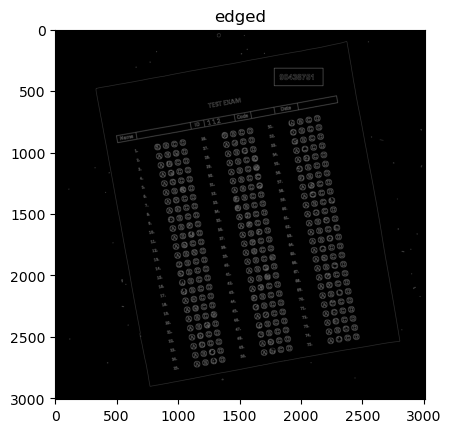

In [4]:
mat = extract_bubbles("../Data set/bubble sheet/2/2.jpg")
# for section_idx, section in enumerate(mat):  # Iterate over sections
#     for row_idx, row in enumerate(section):  # Iterate over rows in each section
#         show_images(row, [f"Section {section_idx + 1} - Q{row_idx + 1} Bubble {i+1}" for i in range(len(row))])